На этом семинаре мы познакомимся с моделями, отличными от ARIMA, а также научимся автоматические подбирать параметры ARIMA моделей.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Начнем с библиотеки [Orbit](https://orbit-ml.readthedocs.io/en/stable/about.html).

# Orbit

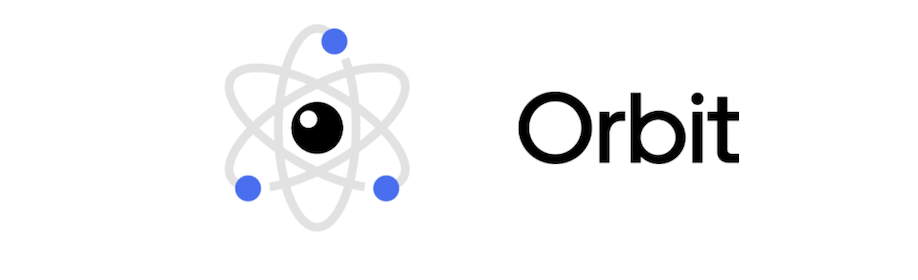

Сссылка: https://github.com/uber/orbit

In [ ]:
!pip install orbit-ml

## Загрузим данные

In [3]:
from orbit.utils.dataset import load_iclaims

Данные `iclaims` содержат еженедельные первоначальные заявки на пособие по безработице в США по нескольким связанным запросам Google Trend (`unemploy`, `filling` и `job`) с января 2010 года по июнь 2018 года.

Первоначальная заявка — это заявка, поданная безработным после увольнения с работодателя. Заявка требует определения основного права на участие в программе страхования по безработице.


*Примечание:* и ответ, и регрессоры преобразуются с помощью логарифма, чтобы проиллюстрировать мультипликативную модель.

Исходные данные: https://orbit-ml.readthedocs.io/en/latest/tutorials/quick_start.html?highlight=load_iclaims#Data

In [ ]:
df = load_iclaims()
df.head()

Построим графики всех колонок в таблице. Наша целевая колонка — **claims**. Именно ее мы будем прогнозировать.

In [ ]:
for fname in df.columns[1:]:
  plt.figure(figsize=(12, 4))
  plt.plot(df['week'].values, df[fname].values)
  plt.xlabel('Time')
  plt.title(fname, size=14)
  plt.grid(b=1)
  plt.tight_layout()
  plt.show()

## Разделим данные на train и test

Возьмем наблюдения за последние 2 года в качестве тестовой выборки. Соотвественно, данные за первые 6 лет будем использовать для обучения наших моделей.

In [6]:
test_size = 52*2 # два последних года

train_df = df[:-test_size]
test_df  = df[-test_size:]

## Модель Damped Local Trend (DLT)

Уравнения модели для прогноза:

$$
y_t = \mu_t + s_t + r_t + \epsilon_t
$$
$$
\mu_t = g_t + l_{t-1} + \theta b_{t-1}
$$
$$
\epsilon_t \sim \text{Student}(\nu, 0, \sigma)
$$
$$
\sigma \sim \text{HalfCauchy}(0, \gamma_0)
$$

Уравнения для обновления:

$$
g_t = D(t)
$$
$$
l_t = \rho_l(y_t - g_t - s_t - r_t) + (1 - \rho_l)(l_{t-1}+\theta b_{t-1})
$$
$$
b_t = \rho_b(l_t - l_{t-1}) + (1 - \rho_b)\theta b_{t-1}
$$
$$
s_{t+m} = \rho_s(y_t - l_{t}-r_t) + (1 - \rho_s)s_t
$$
$$
r_{t} = \sum_{j}\beta_jx_{jt}
$$

где 
- $\rho_{l}$, $\rho_{b}$, $\rho_{s}$ - гиперпараметры модели; 
- $l_t$ - сглаженное значение временного ряда (англ. level); 
- $b_t$ - тренд временного ряда;
- $s_t$ - сезоннная компонента ряда; 
- $g_t$ - детерминированный процесс тренда; 
- $r_t$ - регрессор модели; 
- $\beta_j \sim N(\mu_j, \sigma_j^2)$ - коэффициенты регрессора;
- $x_{jt}$ - признаки наблюдений;


Источник: https://orbit-ml.readthedocs.io/en/stable/tutorials/dlt.html

Документация: https://orbit-ml.readthedocs.io/en/stable/orbit.models.html?highlight=DLTFull#orbit.models.dlt.DLTFull

In [ ]:
from orbit.models import DLT

# инициализируем модель
dlt = DLT(
    response_col='claims', 
    date_col='week',
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=52,
)

# обучаем модель
dlt.fit(df=train_df)

# делаем прогноз
predicted_df = dlt.predict(df=test_df)

# выводим таблицу прогноза
predicted_df.head()

In [ ]:
# построим график прогноза с доверительными интервалами
from orbit.diagnostics.plot import plot_predicted_data

plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df
)

### Метрики качества прогноза

**1. (R)MSE ((Root) Mean Squared Error)**

$$ L(\hat{y}, y) = \frac{1}{N}\sum\limits_{n=1}^N (y_n - \hat{y}_n)^2$$

**2. MAE (Mean Absolute Error)**

$$ L(\hat{y}, y) = \frac{1}{N}\sum\limits_{n=1}^N |y_n - \hat{y}_n|$$

**3. RSE (Relative Squared Error)**

$$ L(\hat{y}, y) = \sqrt\frac{\sum\limits_{n=1}^N (y_n - \hat{y}_n)^2}{\sum\limits_{n=1}^N (y_n - \bar{y})^2}$$

**4. RAE (Relative Absolute Error)**

$$ L(\hat{y}, y) = \frac{\sum\limits_{n=1}^N |y_n - \hat{y}_n|}{\sum\limits_{n=1}^N |y_n - \bar{y}|}$$

**5. MAPE (Mean Absolute Persentage Error)**

$$ L(\hat{y}, y) = \frac{100}{N} \sum\limits_{n=1}^N\left|\frac{ y_n - \hat{y}_n}{y_n}\right|$$


**6. RMSLE (Root Mean Squared Logarithmic Error)**

$$ L(\hat{y}, y) = \sqrt{\frac{1}{N}\sum\limits_{n=1}^N(\log(y_n + 1) - \log(\hat{y}_n + 1))^2}$$

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

def regression_quality_metrics_report(y_true, y_pred):
    
    rmse = np.sqrt( mean_squared_error(y_true, y_pred) )
    mae = mean_absolute_error(y_true, y_pred)
    rse = np.sqrt( ( (y_true - y_pred)**2 ).sum() / ( (y_true - y_true.mean())**2 ).sum() )
    rae = np.abs( y_true - y_pred ).sum() / np.abs( y_true - y_true.mean() ).sum()
    mape = 100. / len(y_true) * np.abs( 1. - y_pred/y_true ).sum()
    rmsle = np.sqrt( mean_squared_log_error(y_true, y_pred) )
    
    return [rmse, mae, rse, rae, mape, rmsle]

Посчитаем метрики для модели DLT.

In [ ]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])

metrics_report.loc['DLT', :] = regression_quality_metrics_report(test_df['claims'].values, predicted_df['prediction'].values)

metrics_report

### Задание

По аналогии с предыдущим примером сделайте прогноз ряда с помощью **Local Global Trend (LGT)**. Какое качество прогноза по сравнению с DLT моделью?

Подсказка: используйте `from orbit.models import LGT`. Описание модели приведено в https://orbit-ml.readthedocs.io/en/stable/tutorials/lgt.html.

In [39]:
# Ваш код

# Prophet

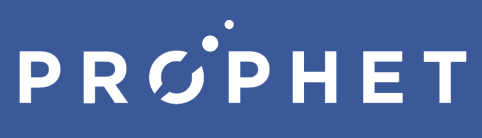

Ссылка: https://facebook.github.io/prophet/

In [ ]:
!pip install prophet

Для начала нам необходимо привести наш временной ряд к нужному формату.

In [ ]:
train_df_prophet = train_df[['week', 'claims', 'trend.unemploy', 'trend.filling', 'trend.job']]
train_df_prophet.columns = ['ds', 'y', 'trend.unemploy', 'trend.filling', 'trend.job']

train_df_prophet.head()

In [ ]:
from prophet import Prophet

# инициализируем модель
model = Prophet(interval_width=0.9)

# добавляем регрессоры
model.add_regressor('trend.unemploy')
model.add_regressor('trend.filling')
model.add_regressor('trend.job')

# обучаем модель
model.fit(train_df_prophet)

Теперь, мы готовы делать прогноз. Но перед этим нам нужно снова привести данные в нужный формат.

In [ ]:
future = test_df[['week', 'trend.unemploy', 'trend.filling', 'trend.job']]
future.columns = ['ds', 'trend.unemploy', 'trend.filling', 'trend.job']

future.head()

In [ ]:
# делаем прогноз на указанные даты
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
# отображаем прогноз на требуемые даты
fig1 = model.plot(forecast)

In [ ]:
# даже можем вывести компоненты прогноза
fig2 = model.plot_components(forecast)

In [ ]:
# посчитаем метрики качества прогноза
metrics_report.loc['Prophet', :] = regression_quality_metrics_report(test_df['claims'].values, forecast['yhat'].values)

metrics_report

# Задание

Попробуйте добавить `sp500` и `vix` в качестве регрессоров. Помогло ли это улучшить качество прогноза? 

In [40]:
# Ваш код


# Sktime

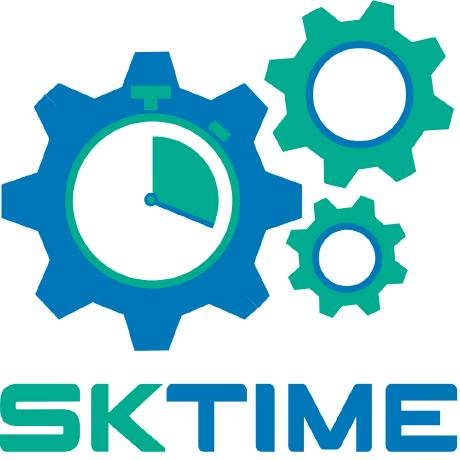

Ссылка: https://github.com/alan-turing-institute/sktime

In [ ]:
!pip install sktime[all_extras]

# AutoARIMA

AutoARIMA осуществляет автоматический подбор параметров модели (S)ARIMA.
ARIMA — это комбинация авторегрессионной модели AR, скользящего среднего MA и дифференцирования временного ряда I (https://otexts.com/fpp3/arima.html).


(S)ARIMA задается семью параметрами: (p, d, q) для прогноза очищенного от сезонности ряда, (P, D, Q)m для прогноза сезонной компоненты временного ряда. А именно:

- p - число предыдущих значений ряда в авторегрессионной AR модели;
- d - порядок дифференцирования входного ряда;
- q - порядо MA модели скользящего среднего;
- P - число предыдущих значений ряда в авторегрессионной AR модели для сезонной компоненты;
- D - порядок дифференцирования входного ряда для сезонной компоненты;
- Q - порядо MA модели скользящего среднего для сезонной компоненты;
- m - число измерений в одном периоде. В нашем случае m=52.

Документация: https://www.sktime.org/en/stable/index.html
https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html#sktime.forecasting.arima.AutoARIMA

Вы можете предположить, что формат данных у этой библиотеки должен быть похож на предыдущие примеры. Но нет. Данные здесь подаются совсем по-другому.

Поэтому наш первый шаг — привести наш верменной ряд к нужному формату. 

In [29]:
# преобразуем pd.DataFrame в pd.Series
trains_ts = pd.Series(data=train_df['claims'].values, index=train_df['week'].values)
trains_ts.index.freq="W"

Теперь мы готовы обучить нашу модель.

In [ ]:
%%time
from sktime.forecasting.arima import AutoARIMA

# инициализация модели
# ВНИМАНИЕ: если взять более широкие границы параметров, то обучение займет очень много времени и ОЗУ (AutoARIMA не болей)
forecaster = AutoARIMA(start_p=1, d=None, start_q=0, 
                       max_p=2, max_d=1, max_q=0, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=0, 
                       sp=52, suppress_warnings=True, stepwise=False, n_jobs=-1)

# обучение модели
forecaster.fit(trains_ts)

In [ ]:
# посмотрим какие параметры являются оптимальными
forecaster.summary()

Теперь переведем данные тестирования в нужный формат, чтобы мы смогли сделать прогноз. И, собственно, сделаем прогноз!

In [32]:
from sktime.forecasting.base import ForecastingHorizon

# pd.DataFrame -> pd.Series
test_ts = pd.Series(data=test_df['claims'].values, index=test_df['week'].values)
test_ts.index.freq="W"

# о да! для погноза свой формат
fh = ForecastingHorizon(test_ts.index, is_relative=False)

In [ ]:
# получаем прогноз и доверительные интервалы
y_pred, y_intervals = forecaster.predict(fh, return_pred_int=True)

In [ ]:
# так выглядит прогноз
y_pred.head()

In [ ]:
# так выглядят доверительные интервалы
y_intervals.head()

Переведем полученный прогноз в удобный для нас формат. Этот формат аналогичен тому, что мы использовали в примере с orbit.

In [ ]:
predicted_df_arima = pd.DataFrame()
predicted_df_arima['week'] = test_df['week']
predicted_df_arima['prediction_5'] = y_intervals['lower'].values
predicted_df_arima['prediction'] = y_pred.values
predicted_df_arima['prediction_95'] = y_intervals['upper'].values

predicted_df_arima.head()

In [ ]:
# нарисуем прогноз и доверительные интервалы
plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df_arima,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df
)

In [ ]:
# посчитаем метрики качества прогноза
metrics_report.loc['AutoARIMA', :] = regression_quality_metrics_report(test_df['claims'].values, predicted_df_arima['prediction'].values)

metrics_report